In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Función para convertir mm:ss.ss a segundos
def mm_ss_to_seconds(mm_ss):
    mm, ss = mm_ss.split(':')
    mm = int(mm)
    ss = float(ss)
    return mm * 60 + ss

# Función para convertir segundos a mm:ss.ss
def seconds_to_mm_ss(seconds):
    mm = int(seconds // 60)
    ss = seconds % 60
    return f"{mm}:{ss:05.2f}"

def mmin_to_kmh(velocity_mmin):
    return velocity_mmin * 60 / 1000

def kmh_to_mmin(velocity_kmh):
    return velocity_kmh * 1000 / 60

def mmin_to_pace(velocity_mmin):
    return 1000 / velocity_mmin  # minutes per km

def pace_to_mmin(pace):
    return 1000 / pace  # m/min

def kmh_to_pace(velocity_kmh):
    velocity_mmin = kmh_to_mmin(velocity_kmh)
    return mmin_to_pace(velocity_mmin)

def pace_to_kmh(pace):
    velocity_mmin = pace_to_mmin(pace)
    return mmin_to_kmh(velocity_mmin)

In [3]:
# tiempo en minutos
def percent_max(time):
    return 0.8 + 0.1894393 * np.exp(-0.012778 * time) + 0.2989558 * np.exp(-0.1932605 * time)

# velocidad en m/min
def vo2(velocity):
    return -4.60 + 0.182258 * velocity + 0.000104 * velocity**2

def velocity(vo2):
    a = 0.000104
    b = 0.182258
    c = -4.60 - vo2
    discriminant = b**2 - 4*a*c
    if discriminant < 0:
        raise ValueError("No real solution for the given VO2 value.")
    sqrt_discriminant = np.sqrt(discriminant)
    velocity1 = (-b + sqrt_discriminant) / (2*a)
    return velocity1

def vo2max(distance, time):
    velocity = distance / time
    return vo2(velocity) / percent_max(time)

In [4]:
vo2max_cooper = vo2max(3445, 12)
vo2max_velocity = velocity(vo2max_cooper)
print(f"VO2max (Cooper Test): {vo2max_cooper:.2f} ml/kg/min")
print(f"Velocity at VO2max (Cooper Test): {mmin_to_kmh(vo2max_velocity)} km/h")
print(f"Pace at VO2max (Cooper Test): {seconds_to_mm_ss(mmin_to_pace(vo2max_velocity)*60)} min/km")

VO2max (Cooper Test): 56.75 ml/kg/min
Velocity at VO2max (Cooper Test): 17.338699494175575 km/h
Pace at VO2max (Cooper Test): 3:27.63 min/km


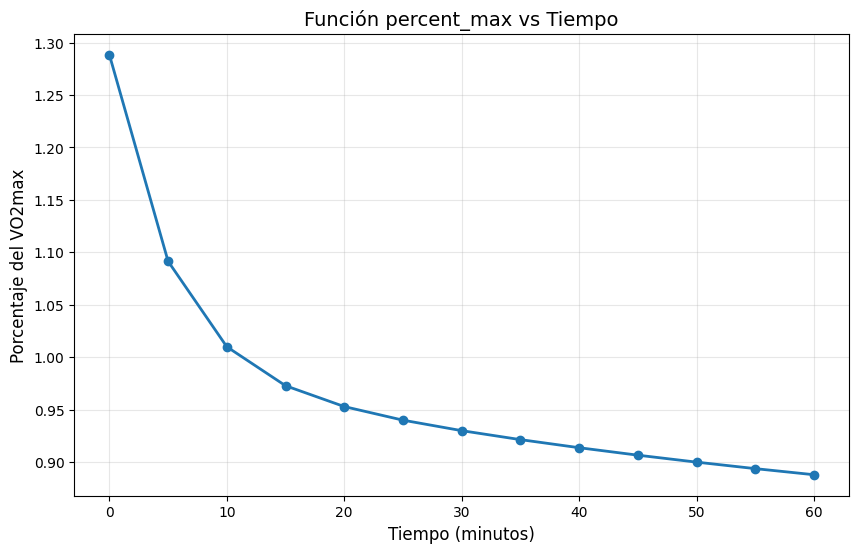

In [5]:
# Plotear percent_max entre 0 y 60 minutos
time_values = np.arange(0, 65, 5)  # De 0 a 60 minutos en intervalos de 5
percent_max_values = [percent_max(t) for t in time_values]

plt.figure(figsize=(10, 6))
plt.plot(time_values, percent_max_values, marker='o', linewidth=2)
plt.xlabel('Tiempo (minutos)', fontsize=12)
plt.ylabel('Porcentaje del VO2max', fontsize=12)
plt.title('Función percent_max vs Tiempo', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

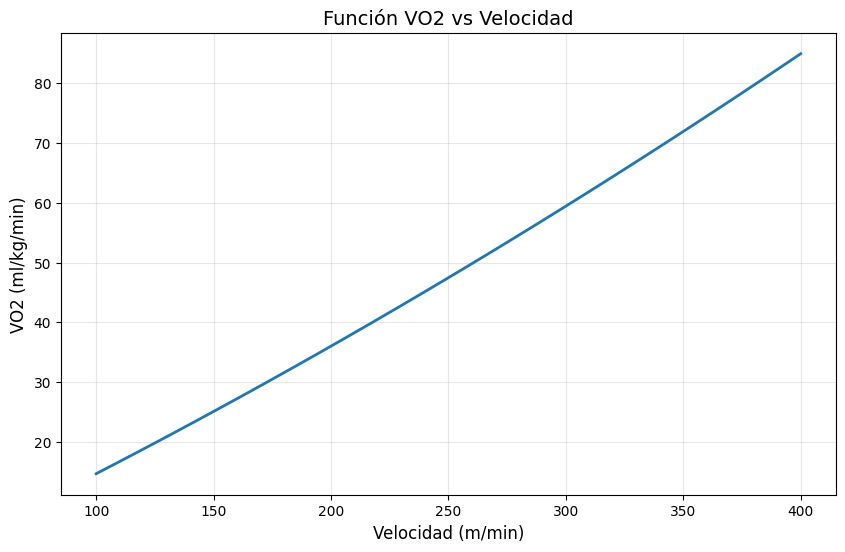

In [6]:
# Plotear vo2 entre 100 y 400 m/min
velocity_values = np.linspace(100, 400, 100)  # De 100 a 400 m/min
vo2_values = [vo2(v) for v in velocity_values]

plt.figure(figsize=(10, 6))
plt.plot(velocity_values, vo2_values, linewidth=2)
plt.xlabel('Velocidad (m/min)', fontsize=12)
plt.ylabel('VO2 (ml/kg/min)', fontsize=12)
plt.title('Función VO2 vs Velocidad', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

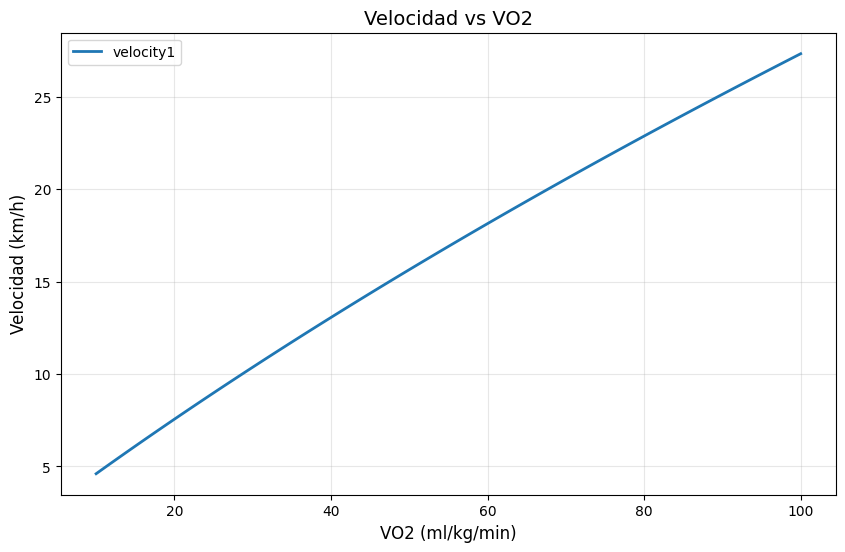

In [7]:
# Plotear velocity1 en función del VO2
vo2_range = np.linspace(10, 100, 100)
velocity1_values = []

for vo2_val in vo2_range:
    a = 0.000104
    b = 0.182258
    c = -4.60 - vo2_val
    discriminant = b**2 - 4*a*c
    if discriminant >= 0:
        sqrt_discriminant = np.sqrt(discriminant)
        v1 = (-b + sqrt_discriminant) / (2*a)
        velocity1_values.append(v1)
    else:
        velocity1_values.append(np.nan)

# Convertir de m/min a km/h (multiplicar por 0.06)
velocity1_kmh = [v * 0.06 for v in velocity1_values]

plt.figure(figsize=(10, 6))
plt.plot(vo2_range, velocity1_kmh, label='velocity1', linewidth=2)
plt.xlabel('VO2 (ml/kg/min)', fontsize=12)
plt.ylabel('Velocidad (km/h)', fontsize=12)
plt.title('Velocidad vs VO2', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

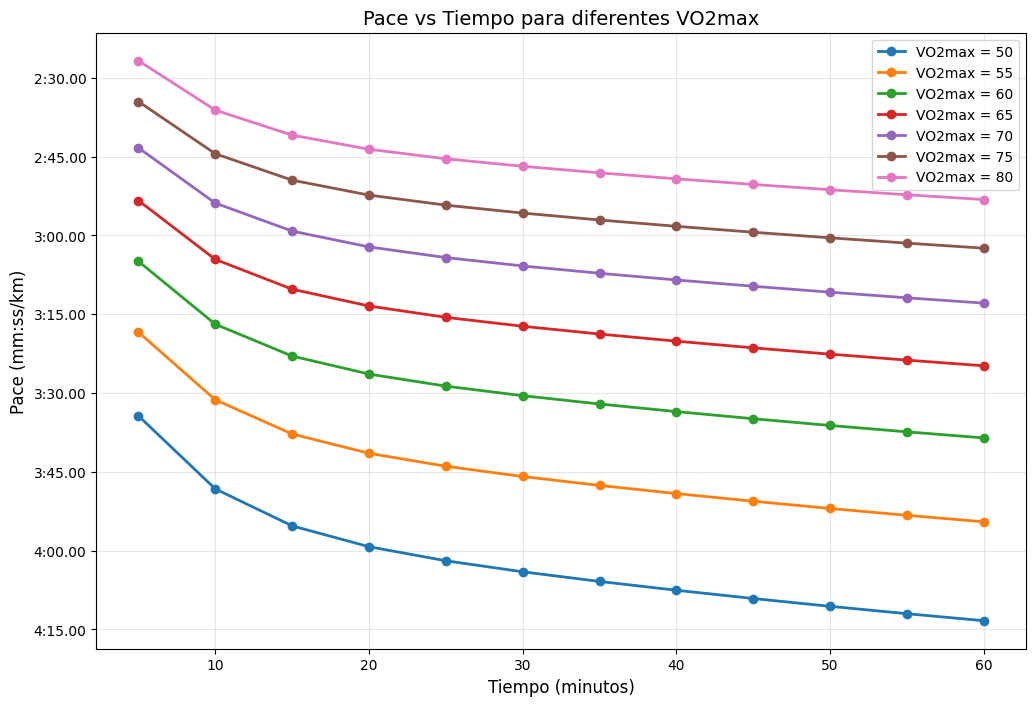

In [8]:
# Graficar pace en función del tiempo para diferentes valores de VO2max
from matplotlib.ticker import FuncFormatter

vo2max_values = [50, 55, 60, 65, 70, 75, 80]
time_range = np.arange(0, 65, 5)  # 0 a 60 minutos en intervalos de 5

plt.figure(figsize=(12, 8))

for vo2max_val in vo2max_values:
    pace_values = []
    for t in time_range:
        if t == 0:
            # En t=0, percent_max es máximo, evitamos división por cero o valores extremos
            pace_values.append(np.nan)
        else:
            # Calcular el VO2 que se puede mantener en ese tiempo
            vo2_at_time = vo2max_val * percent_max(t)
            # Calcular la velocidad correspondiente a ese VO2
            vel = velocity(vo2_at_time)
            # Convertir a pace (min/km)
            pace = mmin_to_pace(vel)
            pace_values.append(pace)
    
    plt.plot(time_range, pace_values, marker='o', linewidth=2, label=f'VO2max = {vo2max_val}')

# Función para formatear el eje Y como mm:ss
def format_pace(y, pos):
    minutes = int(y)
    seconds = (y - minutes) * 60
    return f"{minutes}:{seconds:05.2f}"

plt.xlabel('Tiempo (minutos)', fontsize=12)
plt.ylabel('Pace (mm:ss/km)', fontsize=12)
plt.title('Pace vs Tiempo para diferentes VO2max', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().invert_yaxis()  # Invertir eje Y porque un pace menor es mejor
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_pace))
plt.show()

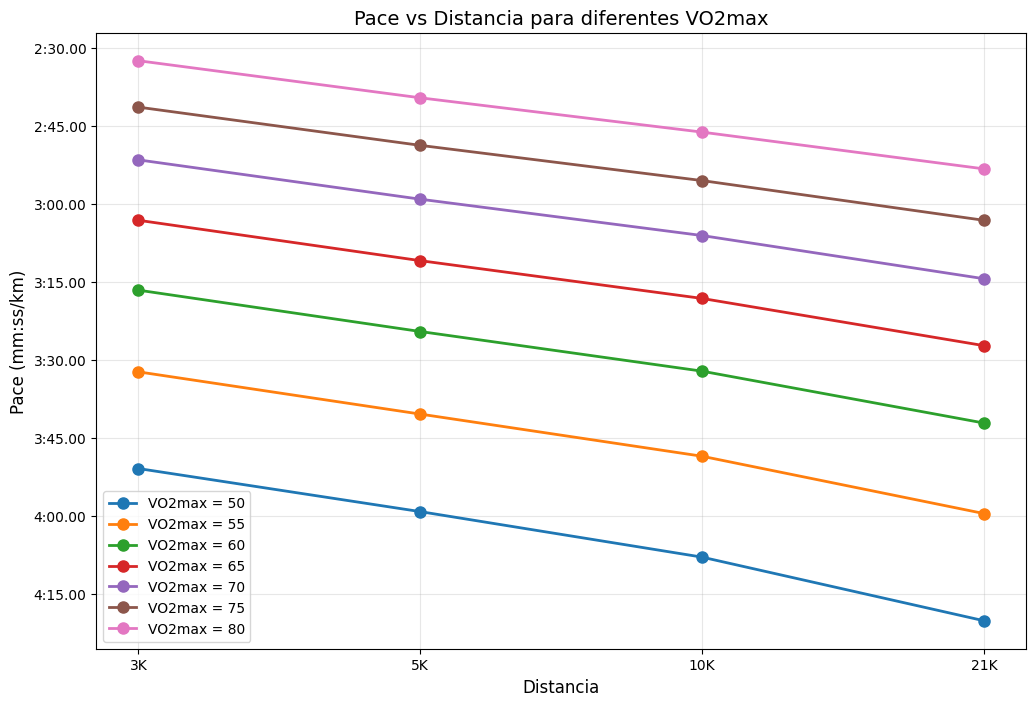

In [9]:
# Graficar pace en función de la distancia para diferentes valores de VO2max
from scipy.optimize import fsolve
from matplotlib.ticker import FuncFormatter

vo2max_values = [50, 55, 60, 65, 70, 75, 80]
distances = [3000, 5000, 10000, 21000]  # 3K, 5K, 10K, 21K en metros
distance_labels = ['3K', '5K', '10K', '21K']

fig, ax = plt.subplots(figsize=(12, 8))

# Guardar datos para el tooltip
all_data = []

for vo2max_val in vo2max_values:
    pace_values = []
    time_values = []
    for distance in distances:
        # Resolver para encontrar el tiempo que permite correr esta distancia
        # La ecuación es: distance = velocity(vo2max * percent_max(time)) * time
        def equation(time):
            if time <= 0:
                return float('inf')
            vo2_at_time = vo2max_val * percent_max(time)
            vel = velocity(vo2_at_time)
            return vel * time - distance
        
        # Estimar tiempo inicial basado en la distancia
        initial_guess = distance / 250  # Asumiendo ~250 m/min como velocidad inicial
        try:
            time_solution = fsolve(equation, initial_guess)[0]
            # Calcular el pace
            pace = time_solution / (distance / 1000)  # min/km
            pace_values.append(pace)
            time_values.append(time_solution)
        except:
            pace_values.append(np.nan)
            time_values.append(np.nan)
    
    line = ax.plot(distance_labels, pace_values, marker='o', linewidth=2, markersize=8, 
                   label=f'VO2max = {vo2max_val}', picker=5)[0]
    
    # Guardar datos para tooltips
    all_data.append({
        'vo2max': vo2max_val,
        'paces': pace_values,
        'times': time_values,
        'distances': distances,
        'distance_labels': distance_labels,
        'line': line
    })

# Función para formatear el eje Y como mm:ss
def format_pace(y, pos):
    minutes = int(y)
    seconds = (y - minutes) * 60
    return f"{minutes}:{seconds:05.2f}"

# Crear anotación para mostrar información
annot = ax.annotate("", xy=(0,0), xytext=(10,10), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w", alpha=0.9),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def on_hover(event):
    if event.inaxes == ax:
        for data in all_data:
            line = data['line']
            if line.contains(event)[0]:
                # Encontrar el punto más cercano
                x_data = np.arange(len(data['distance_labels']))
                y_data = np.array(data['paces'])
                
                # Convertir coordenadas del mouse a índices
                distances_to_mouse = []
                for i, (x, y) in enumerate(zip(x_data, y_data)):
                    if not np.isnan(y):
                        # Distancia en coordenadas de datos
                        dx = abs(event.xdata - x)
                        dy = abs(event.ydata - y)
                        distances_to_mouse.append((i, dx + dy * 0.1))  # Ponderación
                
                if distances_to_mouse:
                    closest_idx = min(distances_to_mouse, key=lambda x: x[1])[0]
                    
                    pace = data['paces'][closest_idx]
                    time_abs = data['times'][closest_idx]
                    dist_label = data['distance_labels'][closest_idx]
                    dist_km = data['distances'][closest_idx] / 1000
                    
                    # Formatear pace y tiempo absoluto
                    pace_str = seconds_to_mm_ss(pace * 60)
                    time_abs_str = seconds_to_mm_ss(time_abs * 60)
                    
                    text = f"VO2max: {data['vo2max']}\n"
                    text += f"Distancia: {dist_label}\n"
                    text += f"Pace: {pace_str}/km\n"
                    text += f"Tiempo total: {time_abs_str}"
                    
                    annot.xy = (closest_idx, pace)
                    annot.set_text(text)
                    annot.set_visible(True)
                    fig.canvas.draw_idle()
                    return
    
    if annot.get_visible():
        annot.set_visible(False)
        fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", on_hover)

ax.set_xlabel('Distancia', fontsize=12)
ax.set_ylabel('Pace (mm:ss/km)', fontsize=12)
ax.set_title('Pace vs Distancia para diferentes VO2max', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.invert_yaxis()  # Invertir eje Y porque un pace menor es mejor
ax.yaxis.set_major_formatter(FuncFormatter(format_pace))
plt.show()